In [132]:
import pandas as pd
import numpy as np
import datetime
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import math
import numpy as np
import random
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import gc

In [2]:
data = pd.read_csv('/Users/Tencent_Go/Desktop/ffm/data/train_de.csv',sep='\t')

In [3]:
data.head()

,userid,offerid,countrycode,category,merchant,utcdate,rating
0,fa937b779184527f12e2d71c711e6411236d1ab59f8597...,c5f63750c2b5b0166e55511ee878b7a3,de,100020213,f3c93baa0cf4430849611cedb3a40ec4094d1d370be841...,2016-06-14 17:28:47.0,0
1,f6c8958b9bc2d6033ff4c1cc0a03e9ab96df4bcc528913...,19754ec121b3a99fff3967646942de67,de,100020213,21a509189fb0875c3732590121ff3fc86da770b0628c18...,2016-06-14 17:28:48.0,0
2,02fe7ccf1de19a387afc8a11d08852ffd2b4dabaed4e2d...,5ac4398e4d8ad4167a57b43e9c724b18,de,125801,b042951fdb45ddef8ba6075ced0e5885bc2fa4c4470bf7...,2016-06-14 17:28:50.0,0
3,9de5c06d0a16256b13b8e7cdc50bf203ecef533eb5cbe1...,be83df9772ec47fd210b28091138ff11,de,125801,4740b6c83b6e12e423297493f234323ffd1c991f3d4496...,2016-06-14 17:29:19.0,0
4,8d26ade603ea5473c3844aebfcd9e96e6adc8ff411576e...,3735290a415dc236bacd7ed3aa03b2d5,de,125801,8bf8f87492a799528235c04bb18ff2d12db5058ff6e9a0...,2016-06-14 17:29:31.0,0


In [8]:
pltdata = data.copy()
pltdata['date'] = pltdata['utcdate'].apply(lambda x: x.split(' ')[0])
pltdata['hour'] = pltdata['utcdate'].apply(lambda x: x.split(' ')[1].split(':')[0])


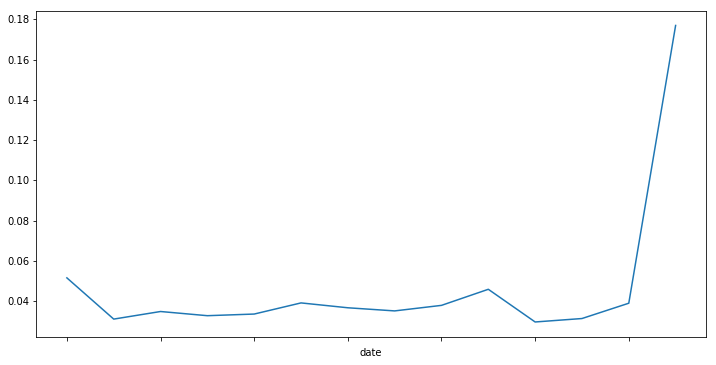

In [9]:
plt.figure(figsize = [12,6])
pltdata.groupby('date')['rating'].mean().plot()
plt.show()


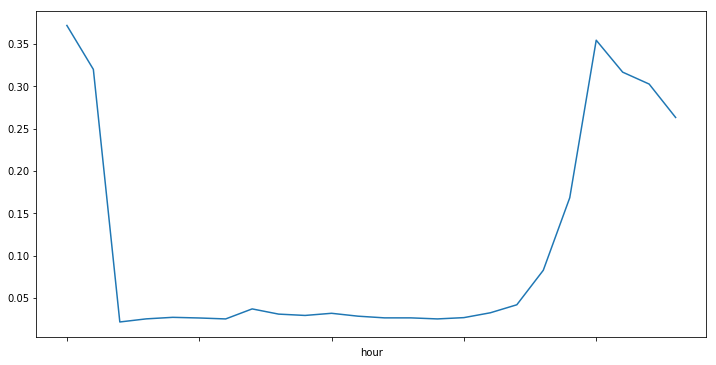

In [10]:
plt.figure(figsize = [12,6])
pltdata.groupby('hour')['rating'].mean().plot()
plt.show()

In [14]:
##添加时间特征，即行为发生在每天的哪个时间段，以及根据是否工作时间创建特征（划分阈值由上图2得到）
data['hour'] = data['utcdate'].apply(lambda x: x.split(' ')[1].split(':')[0]).astype(int)
data['off_work'] = data['hour'].apply(lambda x: 1 if x >= 17 or x <= 1 else 0)

In [15]:
##这部分添加的特征有用户历史浏览数，用户历史浏览的商品数，用户历史浏览的种类数，offerid历史被浏览次数，offerid历史被点击次数
##文中出现%i变量的原因是:我原来是想对时间滑窗构建特征，比如在前1,3,5,7天内用户即商品的相关统计特征，但由于平台资源限制，这里只做了前7天的相关特征；
print ('start adding features...')


start adding features...


In [22]:
def add_feat(data,date1,date2,date3,date4,i):
    #utcdate	UTC的时间，用户加载出(或是看到、被推荐)这条商品的时间
    #utcdate在date1~date2之间的作为train，date3~4之间的作为label
    train_data = data[(data['utcdate'] >= date1) & (data['utcdate'] <= date2)]
    train_label = data[(data['utcdate'] >= date3) & (data['utcdate'] <= date4)]
    
    ###userid相关特征
    label_uid = train_label['userid'].unique()
    print "label_id：",label_uid
    train_userid = train_data[train_data['userid'].isin(label_uid)]
    
    #offerid	商品的唯一标签，因为同一个商品可以推荐给不同的用户，所以商品ID是可以重复的
    ##用户历史浏览数特征：使用count函数合计用户&浏览的商品
    browse = train_userid.groupby(['userid'])['offerid'].count().reset_index()
    browse.columns = ['userid','browse%d'%i]
    train_label = train_label.merge(browse,on=['userid'],how='left')
    
    ##用户历史浏览的商品数：去除重复的（同一用户可能浏览了多次相同的商品）
    subdata1 = train_userid.drop_duplicates(['userid','merchant'])             
    merchant = subdata1.groupby(['userid'])['merchant'].count().reset_index()
    merchant.columns = ['userid','merchant%d'%i]
    train_label = train_label.merge(merchant,on=['userid'],how='left')
    
    ##用户历史浏览的种类数：直接去除重复的category即可
    subdata2 = train_userid.drop_duplicates(['userid','category'])           
    category = subdata2.groupby(['userid'])['category'].count().reset_index()
    category.columns = ['userid','category%d'%i]
    train_label = train_label.merge(category,on=['userid'],how='left')
    
    ###offerid相关特征
    label_offerid = train_label['offerid'].unique()
    train_offer = train_data[train_data['offerid'].isin(label_offerid)]
    
    ##offerid历史被浏览次数
    offerid_num = train_offer.groupby(['offerid'])['userid'].count().reset_index()  
    offerid_num.columns = ['offerid','offerid_num%d'%i]
    train_label = train_label.merge(offerid_num,on=['offerid'],how='left')
    
     ##offerid历史被点击次数
    offer_rating = train_offer.groupby(['offerid'])['rating'].sum().reset_index()  
    offer_rating.columns = ['offerid','offer_rating%d'%i]
    train_label = train_label.merge(offer_rating,on=['offerid'],how='left')
    
    train_label[['browse%d'%i,'merchant%d'%i,'category%d'%i,'offerid_num%d'%i,'offer_rating%d'%i]] = train_label[['browse%d'%i,'merchant%d'%i,'category%d'%i,'offerid_num%d'%i,'offer_rating%d'%i]].fillna(0)
    return train_label
 
    
 
    
  
    
    
    
  

In [23]:
##滑窗构造样本
train1 = add_feat(data,'2016-06-01','2016-06-07','2016-06-08','2016-06-09',i=0)
train2 = add_feat(data,'2016-06-02','2016-06-08','2016-06-09','2016-06-10',i=0)
train3 = add_feat(data,'2016-06-03','2016-06-09','2016-06-10','2016-06-11',i=0)
train4 = add_feat(data,'2016-06-04','2016-06-10','2016-06-11','2016-06-12',i=0)
test = add_feat(data,'2016-06-05','2016-06-11','2016-06-12','2016-06-13',i=0)    


label_id： ['8849ffb9a1513f09518ed3e99f21cffc958c911e4d90efb338f34d05ff4fd037'
 'ab9c9c192e565afa02f91d11e71e0f111ea89e5febaf11dc9ae4d4137c0d62dd'
 'ac557e4203769036a89ffc598bd3bfbcc9b216603dbf14d3aa42f03c9eadde1d' ...
 '0ce2ca3c8d6baa015cd116c8a17d1fe3254a8539d70a9684659416d1a840337e'
 '29458dec6b7132d2b9a47898903333d4c08f46744db8bd688cee078bf98ace14'
 'c5946db011cac4f3c738c8fc871a771ff1359dec56fc16571cd29c19cf5cf131']
label_id： ['687a75ce14da62ffe889edb6d5de3d4c5f7f078ee20c08cdeee7a383a2f80c64'
 '08e5f7745f3ea4aa8a833681724443b20f98c761a52a7b4b43acbc2664b1380b'
 '8a6e026d8a8919c313691477a2602281542460586017298e06c1a0a24384eb1c' ...
 '237b086048fc0f2535b0ed04c7c88f62514d6c8d9f5f389ce1f80fd3548d3f1e'
 '6caf7eb1a97fdee57555548875a25fa6273baa9f8766bc634c7a4b904a4039da'
 'f2521ee86f81ce0e4f58301cc68fd814fc49def7f746030db329a73358719d2a']
label_id： ['c335ef6f0be84e5eef4e016a98fd4617d53f581ab8ed4fb8686cd77974eb570b'
 'b4467c578a22c3c5fda2dfd941fdbd90189d089f1118d7a7055812c1987369f1'
 'f9e8d2

In [25]:
train = pd.concat([train1,train2,train3,train4],axis=0)  
len_train = train.shape[0]
print len_train

4169783


In [26]:
all_data = pd.concat([train,test],axis=0)  
print ('finish adding features...')

finish adding features...


In [27]:
#==================================================转换数据格式============================================================

In [53]:
###将数据格式转换为FFM模型需要的格式，分别对类别型和数值型数据做处理，数值型数据必须做归一化处理，而且处理时训练集和测试集必须在同个
###变换空间内，我一开始是对训练集和测试集分别归一化后，导致结果非常差；修正后效果提升很多。
from sklearn.preprocessing import scale

# 归一化
def minmaxScale(df):
    min_data = df.min()
    max_data = df.max()
    dev_data = max_data-min_data
    return df.map(lambda x:(x-min_data)/dev_data)
    
def FFMFormatPandas(pd_data):
    col_list = pd_data.columns
    field_index = dict(zip(col_list, range(len(col_list))))
    base_index = 0
    ffm=ffm = pd.DataFrame()
    for col in pd_data.columns:
        if pd_data[col].dtype == 'object':
            vals = pd_data[col].unique()
            index_dict = dict(zip(vals,range(len(vals))))
            se = pd_data[col].map(lambda x: (field_index[col],base_index+index_dict[x],1))
            base_index+=len(vals)
            ffm = pd.concat([ffm,se],axis=1)
        else :
            pd_data[col] = np.round(minmaxScale(pd_data[col]),6)
            vals = pd_data[col].unique()
            index_dict = dict(zip(vals,range(len(vals))))
            si= pd_data[col].map(lambda x: (field_index[col],base_index,x))
            base_index+=1
            ffm = pd.concat([ffm,si],axis=1)
        
    return ffm

In [54]:
def data_str_int(df):
    for col in df.columns:
        #if col in ['userid','offerid','category','merchant','date','hour','off_work']:
        if col in ['userid','offerid','category','merchant']:
            df[col] = df[col].map(str)
        else:
            df[col] = df[col].map(int)
    return df

In [55]:
print ('starting FFM...')
train_y = train['rating'].values
test_y = test['rating'].values
all_example = all_data[all_data.columns.difference(['countrycode','utcdate','rating'])]

starting FFM...


In [56]:
all_example = data_str_int(all_example)  
all_X = FFMFormatPandas(all_example)
train_X = all_X[:len_train]
test_X = all_X[len_train:]

In [134]:
        n=feature_num=14
        m=fild_num=6
        k=feature_dim_num=5
        #dic = feat_fild_dic
        #设置超参，学习率eta, 正则化系数lamda
        eta =0.01
        lamda =2
        threshold = 0.05
        w = np.random.rand(n, m , k) / math.sqrt(k)
        #self.G是每轮梯度平方和
        G = np.ones(shape = (feature_num, fild_num, feature_dim_num), dtype = np.float64)

In [135]:
#=============================================================FFM===============================================

In [136]:
def phi(tmp_dict):
        #样本在这要归一化，防止计算溢出
        sum_v = sum(tmp_dict.values())
        #首先先找到每条数据中非0的特征的索引,放到一个列表中
        phi_tmp = 0
        key_list = tmp_dict.keys()
        for i in range(len(key_list)):
            #feat_index是特征的索引,fild_index1是域的索引,value1是特征对应的值
            feat_index1 = key_list[i]
            '''dic'''
            fild_index1 = dic[feat_index1]
            #这里除以sum_v的目的就是对这条进行归一化（将所有特征取值归到0到1之间）
            #当然前面已经对每个特征进行归一化了（0-1）
            value1 = tmp_dict[feat_index1] / sum_v
            #两个非0特征两两內积
            for j in range(i+1, len(key_list)):
                feat_index2 = key_list[j]
                '''self.dic: feat_fild_dic:特征域的dic'''
                fild_index2 = self.dic[feat_index2]
                value2 = tmp_dict[feat_index2] / sum_v
                w=np.random.rand(14, 6 , 5) / math.sqrt(5)
                w1 = w[feat_index1, fild_index2]
                w2 = w[feat_index2, fild_index1]
                #最终的值由多有特征组合求和得到
                phi_tmp += np.dot(w1, w2) * value1 * value2
        return phi_tmp

In [137]:
def sgd_para( tmp_dict, g_phi):
    eta=0.01
    lamda=2
    sum_v = sum(tmp_dict.values())
    key_list = tmp_dict.keys()
    for i in range(len(key_list)):
        feat_index1 = key_list[i]
        '''elf.dic'''
        fild_index1 = self.dic[feat_index1]
        value1 = tmp_dict[feat_index1] / sum_v
        for j in range(i+1, len(key_list)):
            feat_index2 = key_list[j]
            '''self.dict'''
            fild_index2 = self.dic[feat_index2]
            value2 = tmp_dict[feat_index2] / sum_v
            w=np.random.rand(14, 6 , 5) / math.sqrt(5)
            w1 = w[feat_index1, fild_index2]
            w2 = w[feat_index2, fild_index1]
             #更新g以及G
            g_feati_fildj = g_phi * value1 * value2 * w2 + lamda * w1
            g_featj_fildi = g_phi * value1 * value2 * w1 + lamda * w2
            G=np.ones(shape = (14, 6, 5), dtype = np.float64)
            G[feat_index1, fild_index2] += g_feati_fildj ** 2
            G[feat_index2, fild_index1] += g_featj_fildi ** 2
            #math.sqrt()只能接受一个元素，而np.sqrt()可以对整个向量开根
            w[feat_index1, fild_index2] -= eta / np.sqrt(G[feat_index1, fild_index2]) * g_feati_fildj
            w[feat_index2, fild_index1] -= eta / np.sqrt(G[feat_index2, fild_index1]) * g_featj_fildi

In [138]:
def train(tr_l, val_l, train_y, val_y, max_echo):
	#tr_l, val_l, train_y, val_y, max_echo分别是
	#训练集、验证集、训练集标签、验证集标签、最大迭代次数
        minloss = 0
        for i in range(max_echo):
        #迭代训练，max_echo是最大迭代次数
            L_val = 0
            Logloss = 0
            order = range(len(train_y))
            #打乱顺序
            random.shuffle(order)
            for each_data_index in order:
                #取出一条记录
                tr_each_data = tr_l[each_data_index]
                #phi()就是模型公式
                phi = phi(tr_each_data)
                #y_i是实际的标签值
                y_i = float(train_y[each_data_index])
                #下面计算梯度
                g_phi = -y_i/(1 + math.exp(y_i * phi))
                #下面开始用梯度下降法更新模型参数
                sgd_para(tr_each_data, g_phi)
                #接下来在验证集上进行检验，基本过程和前面一样。
            for each_vadata_index, each_va_y in enumerate(val_y):
                val_each_data = val_l[each_vadata_index]
                phi_v = phi(val_each_data)
                y_vai = float(each_va_y)
                Logloss += -(y_vai * math.log(phi_v) + (1 - y_vai) * math.log(1 - phi_v))
            Logloss = Logloss/len(val_y)
                #L_val += math.log(1+math.exp(-y_vai * phi_v))
            print("第%d次迭代, 验证集上的LOGLOSS：%f" %(i ,Logloss))
            if minloss == 0:
                #minloss存储最小的LOGLOSS
                minloss = Logloss
            if Logloss <= threshold:
                #也可以认为设定阈值让程序跳断，个人需要，可以去掉。
                print('小于阈值！')
                break
            if minloss < Logloss:
                #如果下一轮迭代并没有减少LOGLOSS就break出去（early stopping）
                print('early stopping')
                break

In [139]:
train(train_X ,test_X,train_y,test_y,2)

KeyError: 2765377

In [29]:
#======================================================开始训练==========================================================

In [43]:
print ('starting FFM...')
train_y = train['rating'].values
test_y = test['rating'].values
all_example = all_data[all_data.columns.difference(['countrycode','utcdate','rating'])]
def data_str_int(df):
    for col in df.columns:
        #if col in ['userid','offerid','category','merchant','date','hour','off_work']:
        if col in ['userid','offerid','category','merchant']:
            df[col] = df[col].map(str)
        else:
            df[col] = df[col].map(int)
    return df

starting FFM...


In [32]:
#===================================================FFM模型实现==========================================================